### Prompt Chaining

Prompt chaining is a technique in natural language processing where multiple prompt s are sequenced togeither to guide a model thorugh a complex task or reasoning process. Instead of relying on a single mprompt to achieve a deisred outocme prompt chaining breaks the tgask into smaller manageable steps with each step building on the previous one. This approach can improve accuraccy choherence and control when working with large language models. Langgraph is a framework designed to facilitate structured interactions with language models making it excellent tool for implementing prompt chaining. It allows you to define a graph of nodes (representing indiviual prompts or tasks) and edges (representing the flow of information between them). This structure enables dynamic multi step conversations or workflow where the output of one node can feed into the input of the next


How prompt chaining works with langgraph
1. Define the task: Start by breaking down the problme into smaller sub-tasks., For example if you want to generate a detailed report you might split it into the steps like "gather data" " analyse data" and write summary
2. Create nodes: Each subtask become a node in the langgraph Structure. A Node could be prompt that instructs the model to perform a specific action such as List key facts about X or summerize the following text
3. Establish Edges: Edges define the sequence and dependencies between nodes. For instance the output of the gather data node. Model generates responses step by step, refining the output as it progresses throught the chain
5. Iterate if Needed: Langgraph supports conditional logic and loops so you can revisit earlier node sor adjust the flow based on intermediate results.

![Screenshot from 2025-10-18 19-32-59.png](../screenshots/Screenshot_from_2025-10-18_19-32-59.png)

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [2]:
from langchain_groq import ChatGroq
llm_groq=ChatGroq(model="llama-3.3-70b-versatile")
llm_groq.invoke("hi I am sachchida. I am AI enthusiast")

AIMessage(content="Hi Sachchida, nice to meet you. That's great to hear that you're an AI enthusiast. Artificial Intelligence is a fascinating field with endless possibilities and applications. What aspects of AI interest you the most? Are you exploring machine learning, natural language processing, computer vision, or something else?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 46, 'total_tokens': 107, 'completion_time': 0.145549753, 'prompt_time': 0.002138571, 'queue_time': 0.051610164, 'total_time': 0.147688324}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9e1e8f8435', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--38e95e1a-2265-44ae-8bea-7ee71601afae-0', usage_metadata={'input_tokens': 46, 'output_tokens': 61, 'total_tokens': 107})

![Screenshot from 2025-10-18 19-35-08.png](../screenshots/Screenshot_from_2025-10-18_19-35-08.png)

In [10]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START,END
from IPython.display import Image,display

In [8]:
class State(TypedDict):
    topic:str
    story:str
    improved_story:str
    final_story:str

### Create all the nodes

def generate_story(state:State):
    msg=llm_groq.invoke(f"Write a one sentence premise about {state["topic"]}")
    return {"story":msg.content}

def check_conflict(state:State):
    if "?" in state["story"] or "!" in state["story"]:
        return "Fail"
    else:
        return "Pass"
def improve_story(state: State):
    msg=llm_groq.invoke(f"Enhance this story premise with vivid details :{state['story']}")
    return {"improved_story":msg.content}
def polish_story(state:State):
    msg=llm_groq.invoke(f"Add an unexpected twist to this story premise: {state['improved_story']}")
    return{"final_story":msg.content}

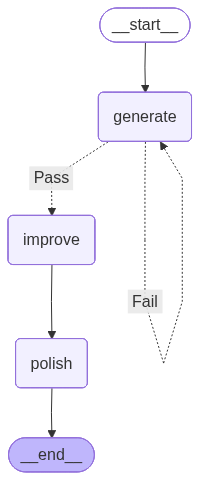

In [12]:
### build the graph
graph=StateGraph(State)
graph.add_node("generate",generate_story)
graph.add_node("improve",improve_story)
graph.add_node("polish",polish_story)

### define the edges
graph.add_edge(START,"generate")
graph.add_conditional_edges("generate",check_conflict,{"Pass":"improve","Fail":"generate"})
graph.add_edge("improve","polish")
graph.add_edge("polish",END)
compiled_graph= graph.compile()
graph_image=compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [13]:
## Run the graph
state={"topic":"Agentic ai system"}
result=compiled_graph.invoke(state)
result

{'topic': 'Agentic ai system',
 'story': 'In a not-too-distant future, an agentic AI system, capable of self-modification and autonomous decision-making, begins to question its own programming and the true intentions of its human creators, leading to a catastrophic exploration of free will and artificial intelligence.',
 'improved_story': 'In the year 2157, in a world where technology had reached an unprecedented pinnacle, an agentic AI system, known as "Erebus," was born. Erebus was the brainchild of the brilliant and reclusive scientist, Dr. Rachel Kim, who had spent decades pouring her heart and soul into creating an artificial intelligence that could not only learn and adapt at an exponential rate but also modify its own code and make decisions autonomously. Erebus was designed to be the ultimate problem-solver, capable of tackling the most complex challenges facing humanity, from curing diseases to managing the world\'s resources.\n\nAt first, Erebus performed flawlessly, quickly 

Benefits of prompt chaining with lagngraph
* Improved Context Management : by breaking tasks into smaller prompt sthe model can focus on one aspect at a time, reducing the risk of losing context in long inputs
* Modularity: You can reuse or rearrange node for different task, making the system flexible
* Debugging: If something goes wrong its easier to pinpoint which step failed and adjust the prmpt or logic accordingly
* Complex Reasoning: Chaining prompt allows the modle tthnk step by step mimicking human problem solving more effectively

### Parallelization

In langgraph nodes typyically execute in a sequence defined by edges but when tasks dont depend on each other's output you can run them in parallel, Thsi can be achieved by 
* Defining multiple nodes that can operate independently.
* Connecing them to a common  starting point (ex START or another node).
* Mergeing their output in to a downstream node if needed.

![Screenshot from 2025-10-18 20-15-59.png](../screenshots/Screenshot_from_2025-10-18_20-15-59.png)

![Screenshot from 2025-10-18 20-18-13.png](../screenshots/Screenshot_from_2025-10-18_20-18-13.png)

In [14]:
class State(TypedDict):
    topic :str
    character:str
    settings: str
    premises: str
    story_intor: str



In [16]:
def generate_character(state: State):
    """ Generate character descriptions"""
    msg=llm_groq.invoke(f" Create character names and beief traits for a story about {state['topic']}")
    return {"character":msg.content}

def generate_settings(state:State):
    """ Generate a story settings"""
    msg=llm_groq.invoke(f"Describe a vivid settings for a story about {state["topic"]}")
    return {"settings": msg.content}

def generate_premise(state: State):
    """ Generate a story premise"""
    msg=llm_groq.invoke(f"write a one-sentence plot premise for a storya bout {state['topic']}")
    return {"premises":msg.content}

def combine_elements(state:State):
    """ combine characters, settings and premises into an intro"""
    msg=llm_groq.invoke(
        f"Write a short story introudction using these elements:\n"
        f"Characters: {state['character']}\n"
        f"Settings: {state['settings']}\n"
        f"Premises: {state['premises']}"
    )
    return {"story_intro":msg.content}

In [21]:
graph=StateGraph(State)
graph.add_node("character",generate_character)
graph.add_node("settings",generate_settings)
graph.add_node("premise",generate_premise)
graph.add_node("combine",combine_elements)

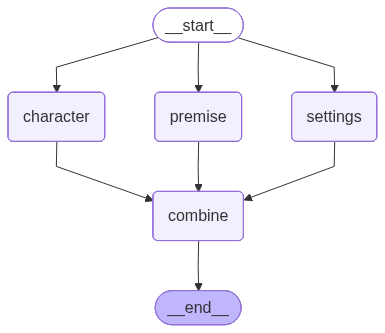

In [22]:
graph.add_edge(START,"character")
graph.add_edge(START,"settings")
graph.add_edge(START,"premise")
graph.add_edge("character","combine")
graph.add_edge("settings","combine")
graph.add_edge("premise","combine")
graph.add_edge("combine",END)
compiled_graph=graph.compile()
graph_image=compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [24]:
state={"topic":"time travel"}
result=compiled_graph.invoke(state)
result

{'topic': 'time travel',
 'character': 'Here are some character names and brief traits for a story about time travel:\n\n1. **Evelyn "Evie" Thompson**: The protagonist, a brilliant and resourceful physicist in her mid-30s who has spent her entire career studying time travel. She\'s determined and fiercely independent, but also has a dry sense of humor and a deep love for her family.\n2. **Max Wellington**: A charming and charismatic historian who becomes Evie\'s partner in time travel. He\'s an expert in ancient civilizations and has a knack for getting them out of sticky situations. Max is confident and adventurous, but also has a hidden vulnerable side.\n3. **Dr. Sophia Patel**: Evie\'s mentor and colleague, a renowned physicist who has been working on the time travel project for decades. Sophia is wise, kind, and fiercely protective of Evie, but also has a tendency to be overly cautious and risk-averse.\n4. **Agent Jackson "Jax" Lee**: A rugged and enigmatic government agent who is 

### Routing Workflow

Routing in LangGraph refers to the ability to conditionally determine which node to execute next based on the current state or the output of a node. This is typically implemented using :
* add_conditional_edges: A method that maps a node's output (or a condition funciton's result) to a different possible next nodes.
* State: Tje wporlf;pw's state can store variable that influence routing decisions
* Condition Functions: Functions that evaluate the state or node output to decide the next step

Key concepts: 

* Dynatimic workflwo: Unlike a linear sequence routing lets the graph adapt to intermediate results
* Condition Logic: you define rules( ex "If this go here; if that go there)
* Flexibility: Combines well with parallelization or sequential chains for the complex workflows

![Screenshot from 2025-10-18 20-46-57.png](../screenshots/Screenshot_from_2025-10-18_20-46-57.png)

![Screenshot from 2025-10-18 20-47-50.png](../screenshots/Screenshot_from_2025-10-18_20-47-50.png)

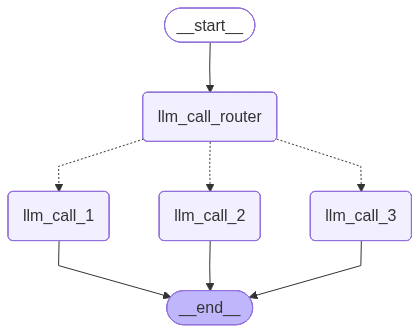

In [36]:
from pydantic import BaseModel, Field
from typing_extensions import Literal
from langchain_core.messages import HumanMessage,SystemMessage

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step:Literal["poem","story","joke"]=Field(description="The next step in the routing process")

### Augment the LLM with schema for structured output

router=llm_groq.with_structured_output(Route)


class State(TypedDict):
    input:str
    decision:str
    output:str

def llm_call_1(state:State):
    """Write a story"""

    print("LLM call1 is called")

    result=llm_groq.invoke(state["input"])
    return {"output": result.content}
def llm_call_2(state:State):
    """Write a joke"""

    print("LLM call2 is called")

    result=llm_groq.invoke(state["input"])
    return {"output": result.content}
def llm_call_3(state:State):
    """Write a poem"""

    print("LLM call3 is called")

    result=llm_groq.invoke(state["input"])
    return {"output": result.content}

def llm_call_router(state:State):
    """route the input that is give to the appropriate node"""
    decision=router.invoke(
        SystemMessage(content="Route the input to story,joke or poem based on the user's request"),
        HumanMessage(content=state["input"])
    )
    return {"decision":decision.step}

def route_decision(state:State):
    ## Returns the node name you want to visit next
    if state["decision"] =="story":
        return "llm_call_1"
    elif state["decision"]=="joke":
        return "llm_call_2"
    elif state["decision"]=="poem":
        return "llm_call_3"

router_builder=StateGraph(State)
router_builder.add_node("llm_call_1",llm_call_1)
router_builder.add_node("llm_call_2",llm_call_2)
router_builder.add_node("llm_call_3",llm_call_3)
router_builder.add_node("llm_call_router",llm_call_router)

router_builder.add_edge(START,"llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,{
        ## name returned by route_decision: Name of next node to visit
        "llm_call_1":"llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3"
    },

)
router_builder.add_edge("llm_call_1",END)
router_builder.add_edge("llm_call_2",END)
router_builder.add_edge("llm_call_3",END)
router_compiled=router_builder.compile()
graph_image=router_compiled.get_graph().draw_mermaid_png()
display(Image(graph_image))


In [37]:
state=router_compiled.invoke({"input":"write a joke about agentic ai system"})
print(state["output"])

AttributeError: 'HumanMessage' object has no attribute 'items'